# Analisis Sentimen dengan TF-IDF

Text classification adalah sebuah proses klasifikasi data dalam bentuk teks seprti tweet, review, artikel dan blog ke dalam katagori yang telah ditentukan. analisis sentimen adalah spesial case dari teks classification, yaitu dimana pendapat atau sentimen pengguna tentang produk apapun dapat diprediksi dari data tekstual

kita akan belajar mengembangkan model analisis sentimen yang akan mengugnakna pendekatan pada pembuatan fitur TF-idf dan akan mampu memprediksi sentimen pengguna tentang 6 maskapai penerbangan yang beroperasi di amerika serikat dengan menganalisis melalu tweet pengguna twitter.

In [3]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/rasyidev/well-known-datasets/main/Tweets.csv')

t_1 = data[data['airline_sentiment']=='positive']
t_2 = data[data['airline_sentiment']=='negative']
tweets = pd.concat([t_1,t_2])

In [6]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)
11,570289724453216256,positive,1.0000,NaN,NaN,Virgin America,NaN,HyperCamiLax,NaN,0,@VirginAmerica I &lt;3 pretty graphics. so muc...,NaN,2015-02-24 10:30:40 -0800,NYC,America/New_York


In [9]:
tweets.shape

(11541, 15)

## Eksplorasi Data

(array([0, 1]), [Text(0, 0, 'positive'), Text(1, 0, 'negative')])

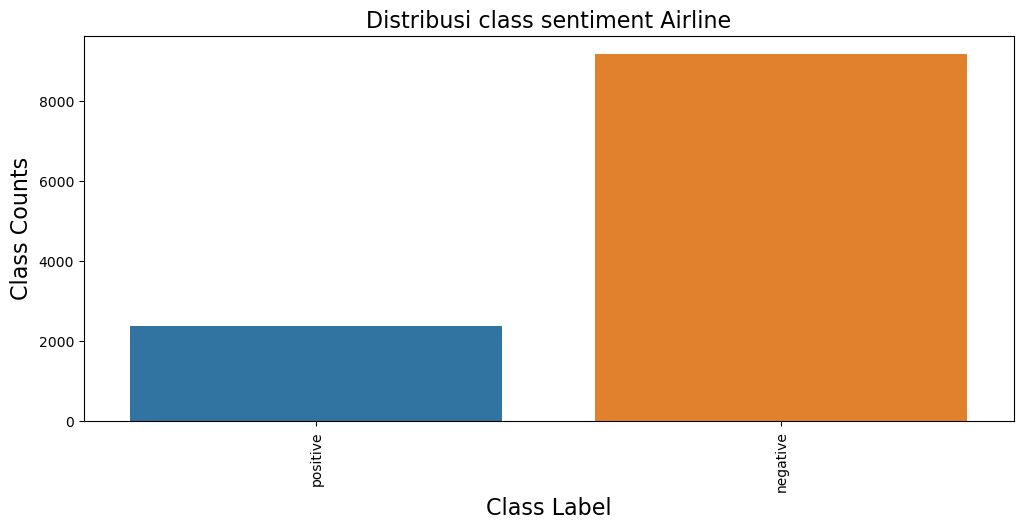

In [10]:
plt.figure(figsize=(12,5))
sns.countplot(x='airline_sentiment', data=tweets)
plt.title('Distribusi class sentiment Airline', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical')

<Axes: xlabel='airline', ylabel='count'>

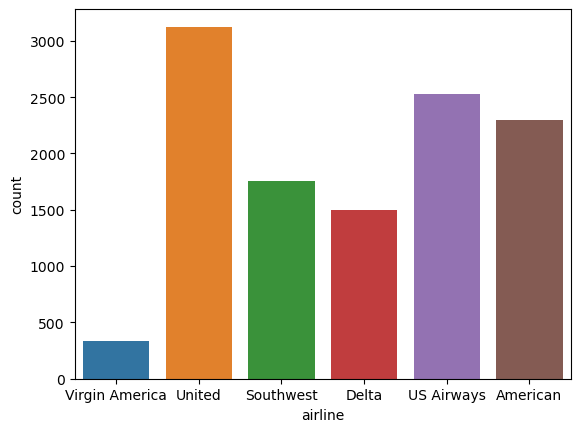

In [11]:
sns.countplot(x='airline',data=tweets)

<Axes: xlabel='airline', ylabel='count'>

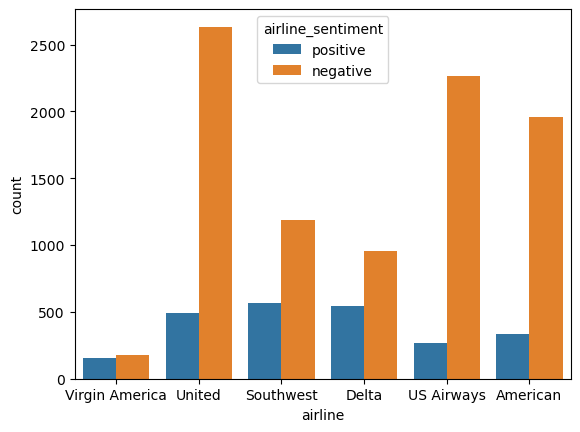

In [12]:
sns.countplot(x='airline', hue='airline_sentiment', data=tweets)

### Pemroresan Data

In [14]:
from sklearn.preprocessing import LabelEncoder

x = tweets.iloc[:,10].values
le = LabelEncoder()
le.fit(['positive','negative'])

print(list(le.classes_))
y=le.transform(tweets.iloc[:,1].values)

print(x.shape)
print(x[0])
print(y.shape)
print(y[0])

['negative', 'positive']
(11541,)
@VirginAmerica plus you've added commercials to the experience... tacky.
(11541,)
1


In [20]:
processed_tweets = []

for tweet in range(0, len(x)):
    #hapus semua spesial karakter
    processed_tweet = re.sub(r'\W',' ', str(x[tweet]))

    #hapus semua single characters
    processed_tweet = re.sub(r'\s+[a-zA-z]s+',' ', processed_tweet)

    #hapus single karakter dari awal
    processed_tweet = re.sub(r'\^[a-zA-z]s+',' ', processed_tweet)

    #subsitusi multipe spaces with single space
    processed_tweet = re.sub(r'\s+',' ', processed_tweet, flags=re.I)

    #hapus prefixed 'b'
    processed_tweet = re.sub(r'\^b\s+',' ', processed_tweet)

    #ubah menjadi lowercase
    processed_tweet = processed_tweet.lower()

    #masukkan ke list kosong yang telah dibuat sebelumnya
    processed_tweets.append(processed_tweet)


Mari kita lihat apa yang terjadi dalam skrip di atas. Pada dasarnya terdiri dari berbagai jenis ekspresi reguler untuk melakukan preprocessing teks. Ekspresi reguler `re.sub(r'\W', ' ', str(X[tweet]))` berfungsi untuk menghapus semua karakter khusus dari tweet.

Ketika menghapus karakter khusus, Kita hanya memiliki satu karakter yang tidak memiliki arti. Misalnya, ketika menghapus karakter khusus dari kata "Julia's", Kita dibiarkan "Julia" dan "s". Di sini "s" tidak memiliki arti. Ekspresi reguler `re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)` menghapus semua karakter tunggal kecuali yang ada di awal. Untuk menghapus karakter tunggal dari awal kalimat, digunakan regex `re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet)`.

Selanjutnya yaitu hasil dari menghapus karakter khusus dan spasi tunggal, terdapat beberapa spasi muncul dalam teks. Untuk menghapus beberapa spasi ini dan menggantinya dengan spasi tunggal, gunakan regex `re.sub(r'\s+', ' ', processed_tweet, flags=re.I)`.

Dalam beberapa kasus, dataset memiliki format byte. Dalam kasus seperti itu, karakter "b" ditambahkan di awal string. Hapus "b" yang berada didepan dengan menggunakan regex  `re.sub(r'^b\s+', '', processed_tweet)`. Langkah terakhir yaitu ubah teks menjadi huruf kecil untuk menjaga keseragaman.

In [22]:
print(str(x[:5]))

processed_tweet[:5]

["@VirginAmerica plus you've added commercials to the experience... tacky."
 '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)'
 "@virginamerica Well, I didn't…but NOW I DO! :-D"
 "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."
 '@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D']


' amer'

## Skema TF-IDF untuk Pembuatan Feature Numeric

Pendekatan statistik seperti machine learning dan deep learning dapat bekerja dengan baik menggunakan data numerik. Namun, natural language terdiri dari kata-kata dan kalimat. Karena itu, sebelum kita dapat membangun model analisis sentimen, Kita perlu mengubah teks menjadi angka. Beberapa pendekatan telah dikembangkan untuk mengubah teks menjadi angka. Bag of Words, N-gram, dan model Word2Vec adalah beberapa di antaranya.

Pada pembahasan ini, Kita akan menggunakan pendekatan Bag of Words dengan skema TF-IDF, untuk mengkonversi teks menjadi angka. Library Python dari Sklearn dilengkapi dengan fungsi bawaan untuk mengimplementasikan pendekatan TF-IDF yang akan kita gunakan nanti. Di sini kita akan mempelajari wawasan singkat tentang pendekatan TF-IDF.

### Bag of Words

Dalam pendekatan bag of words atau sekumpulan kata-kata, dimana semua kosakata dari kata-kata yang unik dalam semua dokumen terbentuk. Kosakata ini berfungsi sebagai feature vektor. Misalkan Anda memiliki tiga dokumen dalam corpus S1, S2, dan S3:
* S1 = “It is cold outside”
* S2= “The weather is cold”
* S3 = “I am outside”

Kosakata yang dibentuk menggunakan tiga kalimat di atas adalah:
[it, is, cold, outside, the, weather, I,  am]

Kosakata kata-kata ini akan digunakan untuk membuat feature vektor dari kalimat. Kita lihat bagaimana hal itu dilakukan feature vektor pada corpus S1:

* S1= [1, 1, 1, 1, 0, 0, 0, 0]

Pada dasarnya, feature vektor dibuat dengan mencari apakah kata dalam kosakata juga ditemukan dalam kalimat. Jika sebuah kata ditemukan dalam kosakata dan juga dalam kalimat, satu dimasukkan di tempat itu. Jika tidak, maka nol akan dimasukkan. Jadi untuk S1, empat kata pertama dalam kosakata hadir dalam kalimat S1, Kita memiliki empat yang di awal dan kemudian empat nol.

Demikian pula, vektor fitur untuk S2 dan S3 adalah:

* S2 = [0, 1, 1, 0, 1, 1, 0 , 0]

* S3 = [0, 0, 0, 1, 0, 0, 1, 1]

### TF-IDF

Sekarang Kita tahu cara kerja dari bag of word. Sekarang kita akan melihat bagaimana TF-IDF terkait dengan bag of words.

Dalam bag of words yang sederhana, setiap kata diberi arti penting yang sama. Gagasan di balik TF-IDF adalah bahwa kata-kata yang lebih sering muncul dalam satu dokumen dan lebih jarang di dokumen lain harus diberikan prioritas lebih tinggi karena mereka lebih berguna untuk klasifikasi.

TF-IDF adalah produk dari dua istilah: TF dan IDF.

**Term Frequency** adalah sama dengan berapa kali sebuah kata muncul dalam dokumen tertentu. Itu dihitung sebagai:

`TF = (Frekuensi kata dalam dokumen) / (Total kata dalam dokumen)`

**Inverse Document Frequency** adalah untuk kata tertentu sama dengan jumlah total dokumen, dibagi dengan jumlah dokumen yang mengandung kata tertentu. Log seluruh istilah dihitung untuk mengurangi dampak division. Itu dapat dihitung sebagai berikut:

`IDF = Log ((Jumlah total dokumen) / (Jumlah dokumen yang mengandung kata))`

Misalnya, dalam S1, TF untuk kata "outside" akan 1/4 = 0,25. Demikian pula, IDF untuk kata "outside" di S1 akan menjadi Log (3/2) = 0,176. Nilai dari TF-IDF akan menjadi 0,25 x 0,176 = 0,044.

Ini adalah perhitungan yang rumit. Untungnya, Kita tidak harus melakukan semua perhitungan ini. Kelas `TfidfVectorizer` dari modul `sklearn.feature_extraction.text` dapat digunakan untuk membuat vektor fitur yang berisi nilai TF-IDF. Lihatlah skrip berikut:

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7 ,stop_words=stopwords.words('english'), 
                                 ngram_range=(1,3))
x1 = tfidfconverter.fit_transform(processed_tweets).toarray()

Atribut `max_features` menentukan jumlah kata yang paling banyak muncul di mana Anda ingin membuat feature vektor. Kata-kata yang jarang muncul tidak memainkan peran utama dalam klasifikasi. Karenanya kami hanya menyimpan 2000 kata yang paling sering muncul dalam dataset. Nilai `min_df` dari 5 menentukan bahwa kata tersebut harus muncul di setidaknya 5 dokumen. Demikian pula, nilai `max_df` sebesar 0,7 menetapkan bahwa kata tersebut tidak boleh muncul di lebih dari 70 persen dokumen. Alasan di balik memilih 70 persen sebagai ambang batas adalah bahwa kata-kata yang muncul di lebih dari 70 persen dokumen terlalu umum dan kecil kemungkinannya untuk berperan dalam klasifikasi sentimen.

Terakhir, untuk mengonversi dataset menjadi feature vektor TF-IDF yang sesuai, Kita perlu memanggil metode `fit_transform` pada kelas `TfidfVectorizer` dan meneruskannya dengan dataset yang telah kami proses sebelumnya.

## Membagi Data ke Training dan Test Set

Sebelum membangun model analisis sentimen yang sebenarnya, bagi dataset ke training dan test set. Model akan melatih pada training set dan dievaluasi pada test set. Berikut script untuk membagi data menjadi training dan test set:

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, random_state=0)

## Pelatihan dan Evaluasi dari Model Klasifikasi Teks

Kita telah membagi data ke dalam training dan test set, langkah selanjutnya adalah melatih model pada training set dan mengevaluasi kinerjanya pada test set. Sekarang, gunakan `RandomForestClassifier, Naive Bayes dan SVM` dari modul `sklearn` untuk melatih model. Kita dapat menggunakan classifier lainnya sesuai pilihan. Untuk melatih model, Kita perlu memanggil metode "fit" pada objek classifier dan meneruskannya ke training feature set dan training label set seperti yang ditunjukkan di bawah ini:

# Random forest

In [27]:
import time

from sklearn.ensemble import RandomForestClassifier

text_classifier_en = RandomForestClassifier(n_estimators=100, random_state=0)
t0_en = time.time()
text_classifier_en.fit(x_train, y_train)
t1_en = time.time()

# Naive Bayes

In [29]:
from sklearn.naive_bayes import GaussianNB
text_classifier_nb = GaussianNB()
t0_nb = time.time()
text_classifier_nb.fit(x_train, y_train)
t1_nb = time.time()

# Sklearn

In [30]:
from sklearn.svm import SVC
text_classifier_svm = SVC(kernel='linear')
t0_svm = time.time()
text_classifier_svm.fit(x_train, y_train)
t1_svm = time.time()

Untuk membuat prediksi pada test set, Kita harus melewati test set ke metode "predict" seperti yang ditunjukkan di bawah ini:

In [32]:
predictions_en = text_classifier_en.predict(x_test)
t2_en = time.time()
time_linier_train_en = t1_en - t0_en
time_linier_predict_en = t2_en - t1_en

predictions_nb = text_classifier_nb.predict(x_test)
t2_nb = time.time()
time_linier_train_nb = t1_nb - t0_nb
time_linier_predict_nb = t2_nb - t1_nb

predictions_svm = text_classifier_svm.predict(x_test)
t2_svm = time.time()
time_linier_train_svm = t1_svm - t0_svm
time_linier_predict_svm = t2_svm - t1_svm

#training time, prediction time
print(time_linier_train_en,time_linier_predict_en)
print(time_linier_train_nb,time_linier_predict_nb)
print(time_linier_train_svm,time_linier_predict_svm)

21.008885145187378 408.833370923996
0.23864269256591797 294.7588288784027
22.99062490463257 220.05138230323792


## Results

Terakhir, untuk mengevaluasi model klasifikasi yang digunakan, Kita dapat menggunakan *classification_report, confusion_matrix, accuracy_score, recall_score, precision_score,* dan *f1_score, roc_auc_score* sebagai performance metrics. Metrics ini dapat dihitung menggunakan class dari modul `sklearn.metrics` seperti yang ditunjukkan di bawah ini:

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

print("Random Forest")
print('Accuracy  = ', round(accuracy_score(y_test, predictions_en)*100,2),'%')
print('Recall    = ', round(recall_score(y_test, predictions_en)*100,2),'%')
print('Precision = ', round(precision_score(y_test, predictions_en)*100,2),'%')
print('F1-Score  = ', round(f1_score(y_test, predictions_en)*100,2),'%')
print('ROC AUC   = ', roc_auc_score(y_test, predictions_en))
print("")
print("Naive Bayes")
print('Accuracy  = ', round(accuracy_score(y_test, predictions_nb)*100,2),'%')
print('Recall    = ', round(recall_score(y_test, predictions_nb)*100,2),'%')
print('Precision = ', round(precision_score(y_test, predictions_nb)*100,2),'%')
print('F1-Score  = ', round(f1_score(y_test, predictions_nb)*100,2),'%')
print('ROC AUC   = ', roc_auc_score(y_test, predictions_nb))
print("")
print("Support Vector Machine")
print('Accuracy  = ', round(accuracy_score(y_test, predictions_svm)*100,2),'%')
print('Recall    = ', round(recall_score(y_test, predictions_svm)*100,2),'%')
print('Precision = ', round(precision_score(y_test, predictions_svm)*100,2),'%')
print('F1-Score  = ', round(f1_score(y_test, predictions_svm)*100,2),'%')
print('ROC AUC   = ', roc_auc_score(y_test, predictions_svm))
print("")

print("Random Forest")
print(confusion_matrix(y_test,predictions_en))
print("")
print("Naive Bayest")
print(confusion_matrix(y_test,predictions_nb))
print("")
print("Support Vector Machine")
print(confusion_matrix(y_test,predictions_svm))
print("")

print("Random Forest")
print(classification_report(y_test,predictions_en))
print("")
print("Naive Bayest")
print(classification_report(y_test,predictions_nb))
print("")
print("Support Vector Machine")
print(classification_report(y_test,predictions_svm))
print("")

Random Forest
Accuracy  =  89.0 %
Recall    =  60.36 %
Precision =  78.1 %
F1-Score  =  68.09 %
ROC AUC   =  0.7813516296668822

Naive Bayes
Accuracy  =  65.83 %
Recall    =  87.31 %
Precision =  34.88 %
F1-Score  =  49.84 %
ROC AUC   =  0.7397514189237733

Support Vector Machine
Accuracy  =  91.47 %
Recall    =  68.6 %
Precision =  84.62 %
F1-Score  =  75.77 %
ROC AUC   =  0.8279306463586943

Random Forest
[[1784   76]
 [ 178  271]]

Naive Bayest
[[1128  732]
 [  57  392]]

Support Vector Machine
[[1804   56]
 [ 141  308]]

Random Forest
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1860
           1       0.78      0.60      0.68       449

    accuracy                           0.89      2309
   macro avg       0.85      0.78      0.81      2309
weighted avg       0.88      0.89      0.88      2309


Naive Bayest
              precision    recall  f1-score   support

           0       0.95      0.61      0.74      1860
     

### Testing Prediksi

In [36]:
#Random Forest
review = "Comfort for passenger"

review_vector = tfidfconverter.transform([review]).toarray()
pred_text = text_classifier_en.predict(review_vector)
pred_text = le.inverse_transform(pred_text)
print(pred_text)

['negative']


In [37]:
#Naive Bayest
review = "Comfort for passenger"

review_vector = tfidfconverter.transform([review]).toarray()
pred_text = text_classifier_nb.predict(review_vector)
pred_text = le.inverse_transform(pred_text)
print(pred_text)

['positive']


In [38]:
#Support Vector Machine
review = "Comfort for passenger"

review_vector = tfidfconverter.transform([review]).toarray()
pred_text = text_classifier_svm.predict(review_vector)
pred_text = le.inverse_transform(pred_text)
print(pred_text)

['negative']
